<a href="https://colab.research.google.com/github/Anshikasingla114/TimeSeries-Forcasting-for-StockMarket/blob/main/TimeSeriesCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# For ARIMA/SARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For LSTM
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')


 2. DATA CLEANING

In [ ]:
# Read raw TCS stock data
df = pd.read_csv('tcs_stock.csv')

# Initial validation
print("Data Head:\n", df.head())
print("Info:")
df.info()
print("Description:\n", df.describe())

# Remove duplicate records
df = df.drop_duplicates()

# Check for missing/null values
print("Null values per column:\n", df.isnull().sum())

# Rename columns for consistency
df.rename(columns=lambda name: name.strip().title().replace(' ', '_'), inplace=True)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Remove records with zero volume
df = df[df['Volume'] > 0].reset_index(drop=True)

# Derive new features
df = df.sort_values('Date').reset_index(drop=True)
df['Price_Change'] = df['Close'] - df['Open']
df['Percentage_Change'] = df['Price_Change'] / df['Open'] * 100
df['Daily_Return'] = df['Close'].pct_change()

# Save cleaned data
df.to_csv('tcs_stock_cleaned.csv', index=False)

# For further steps, reload the cleaned data
df = pd.read_csv('tcs_stock_cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'])


Data Head:
          Date Symbol Series  Prev Close    Open     High      Low     Last  \
0  2015-01-01    TCS     EQ     2558.25  2567.0  2567.00  2541.00  2550.00   
1  2015-01-02    TCS     EQ     2545.55  2551.0  2590.95  2550.60  2588.40   
2  2015-01-05    TCS     EQ     2579.45  2581.0  2599.90  2524.65  2538.10   
3  2015-01-06    TCS     EQ     2540.25  2529.1  2529.10  2440.00  2450.05   
4  2015-01-07    TCS     EQ     2446.60  2470.0  2479.15  2407.45  2426.90   

     Close     VWAP   Volume      Turnover  Trades  Deliverable Volume  \
0  2545.55  2548.51   183415  4.674345e+13    8002               52870   
1  2579.45  2568.19   462870  1.188740e+14   27585              309350   
2  2540.25  2563.94   877121  2.248886e+14   43234              456728   
3  2446.60  2466.90  1211892  2.989615e+14   84503              714306   
4  2417.70  2433.96  1318166  3.208362e+14  101741              886368   

   %Deliverble  
0       0.2883  
1       0.6683  
2       0.5207  
3     

3. EDA & VISUALIZATIONS

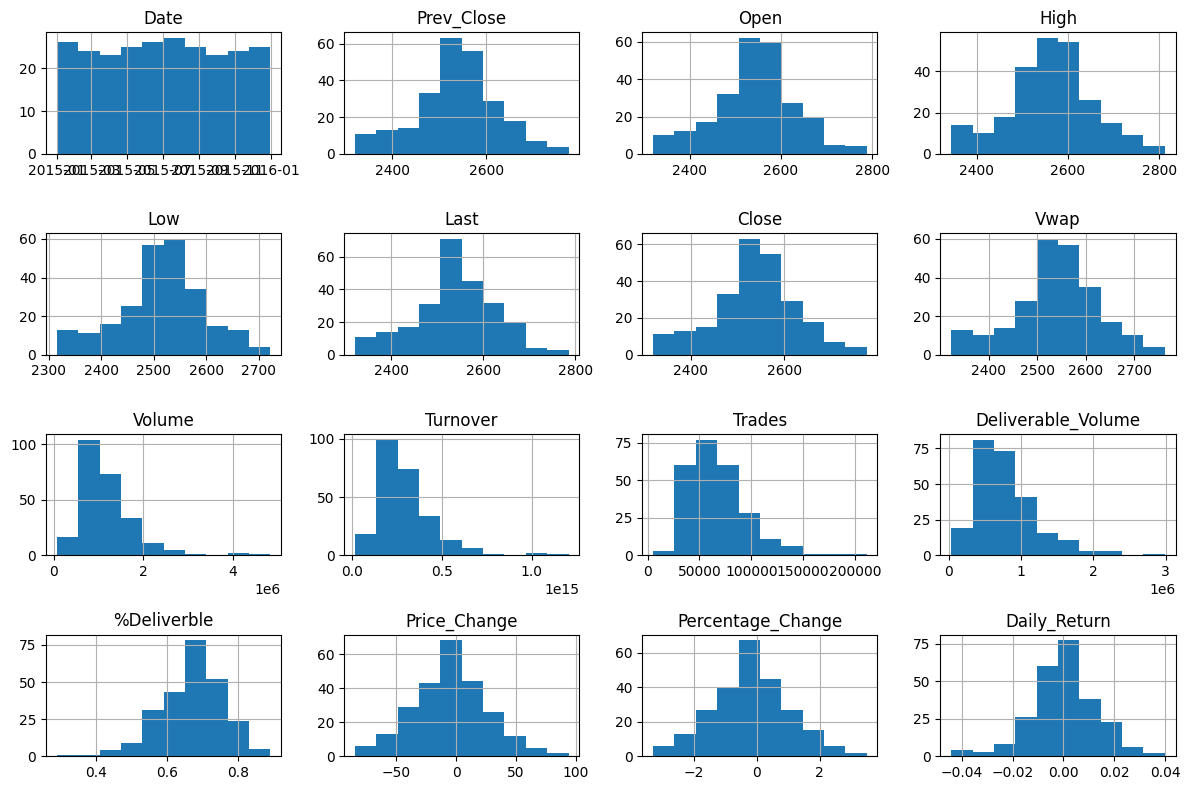

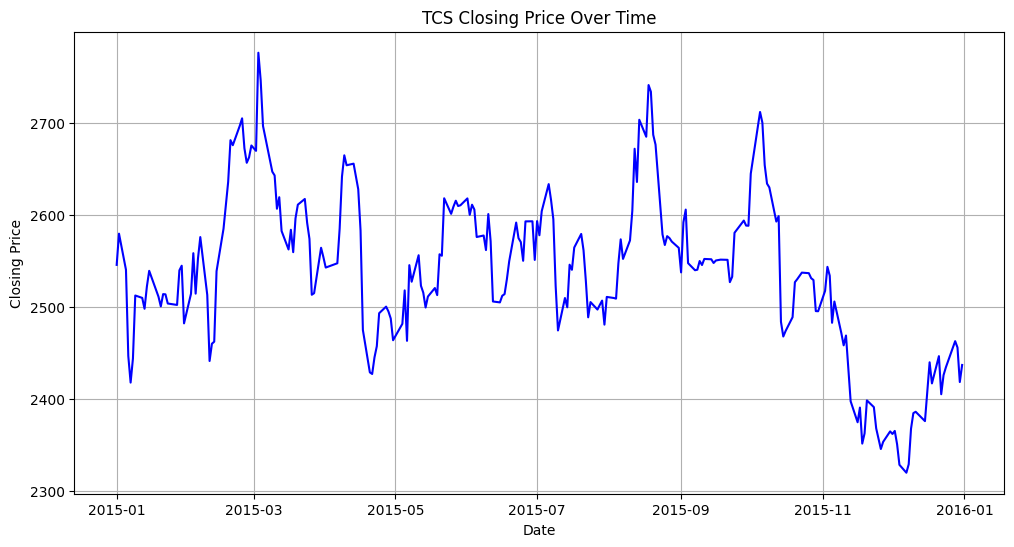

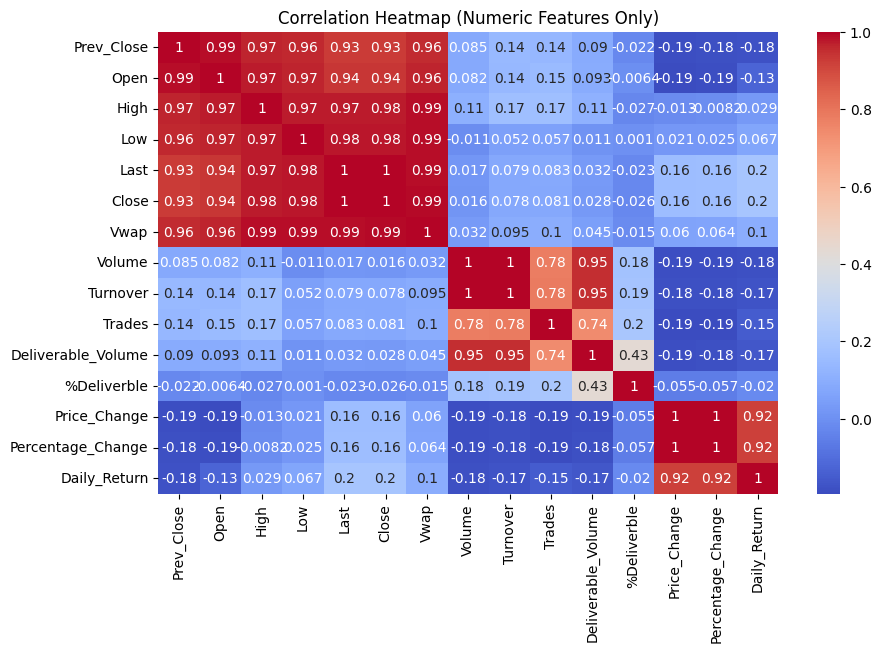

In [ ]:
# Distribution histograms (numeric features)
df.hist(figsize=(12,8))
plt.tight_layout()
plt.show()

# Closing price over time
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], color='blue')
plt.title("TCS Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()

# Correlation heatmap for numeric features
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


 4. TIME SERIES MODELING: ARIMA / SARIMA


ARIMA Model Summary:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  248
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1209.122
Date:                Fri, 01 Aug 2025   AIC                           2430.243
Time:                        08:26:59   BIC                           2451.300
Sample:                             0   HQIC                          2438.721
                                - 248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0690      0.065      1.068      0.285      -0.058       0.196
ar.L2          0.0004      0.061      0.007      0.995      -0.119       0.120
ar.L3         -0.0585      0.

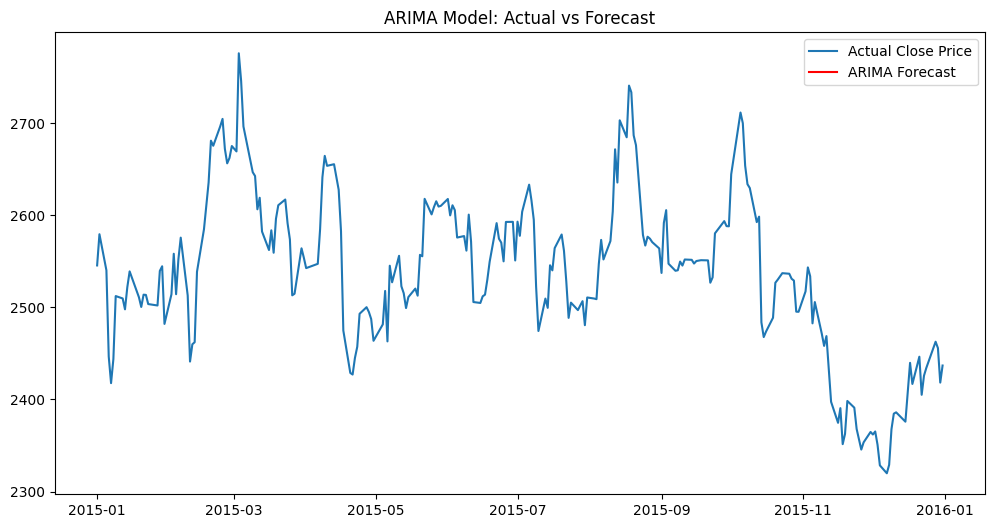

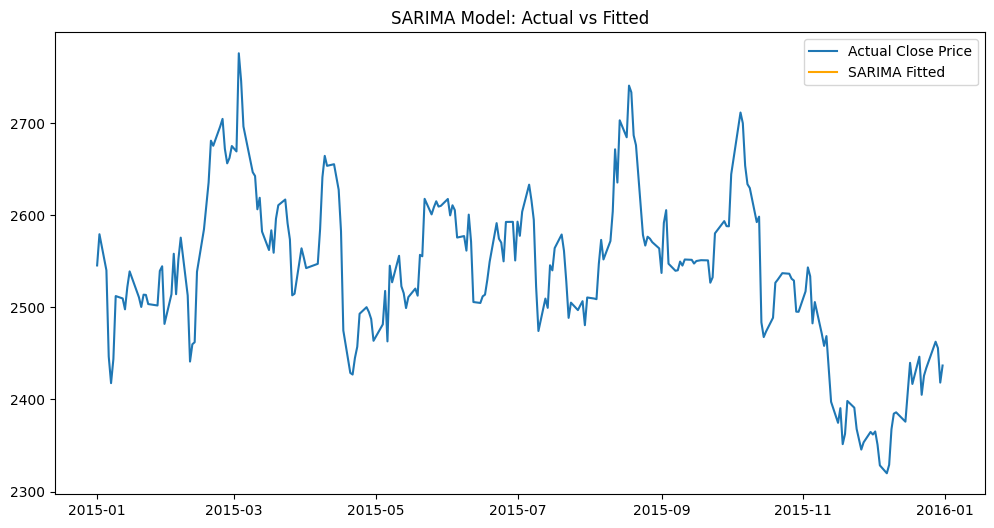

In [ ]:
# (Use only 'Close' price series with non-null values)
ts_data = df[['Date', 'Close']].set_index('Date')['Close']

arima_order = (5, 1, 0)  # Example order (p,d,q)
arima_model = ARIMA(ts_data, order=arima_order)
arima_fit = arima_model.fit()
print("\nARIMA Model Summary:\n", arima_fit.summary())

# In-sample prediction
df['ARIMA_Forecast'] = arima_fit.predict(start=arima_order[1], end=len(ts_data)-1, typ='levels')

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Actual Close Price')
plt.plot(df['Date'][arima_order[1]:], df['ARIMA_Forecast'][arima_order[1]:], color='red', label='ARIMA Forecast')
plt.title('ARIMA Model: Actual vs Forecast')
plt.legend()
plt.show()
#Sarima Model

sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Example seasonal order (P,D,Q,s)
sarima_model = SARIMAX(ts_data, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)
df['SARIMA_Fitted'] = sarima_fit.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Actual Close Price')
plt.plot(df['Date'], df['SARIMA_Fitted'], color='orange', label='SARIMA Fitted')
plt.title('SARIMA Model: Actual vs Fitted')
plt.legend()
plt.show()

5. DEEP LEARNING MODELING: LSTM

Drop the non numeric colums from the data


In [ ]:
numeric_df = df.select_dtypes(include=["int64", "float64"])

In [ ]:
display(numeric_df.head())

Prepare for the lstm model

In [ ]:
target_column = df.filter(["Close"])
data = target_column.values
train_size = int(np.ceil(len(df)*0.95))

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
# Ensure train_size is an integer
train_size = int(np.ceil(len(df)*0.95)) # Keep train_size as an integer
X_train, y_train = [], []

Creating Sequence of 60 days slide window

In [ ]:
sequence_length = 60

# Split data into training and testing sets
# Ensure train_size is used as an integer index
train_data = scaled_data[0:int(train_size), :]
test_data = scaled_data[int(train_size) - sequence_length:, :] # Start test data earlier to include the sequence length for the first test prediction

X_train, y_train = [], [] # Re-initialize as lists before appending

for i in range(sequence_length, len(train_data)):
    X_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Reshape y_train to match the expected output shape
y_train = np.reshape(y_train, (y_train.shape[0], 1))

LSTM layers Implementation

In [ ]:
model=keras.models.Sequential()
model.add(keras.layers.LSTM(64,return_sequences=True, input_shape =(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(64, return_sequences=False))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test)) # Use the corrected y_test

Epoch 1/20
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.0021 - mae: 0.7699

KeyError: 'pop from an empty set'

In [ ]:
# Prepare test data (X_test and y_test)
X_test = []
y_test = []

# The test set for validation starts from train_size.
# Loop through the scaled data starting from train_size up to the end.
for i in range(train_size, len(scaled_data)):
    # Ensure we have enough data points for a full sequence before the current index 'i'.
    # The sequence for X_test should end at index i-1 and start at i - sequence_length.
    if i - sequence_length >= 0:
        X_test.append(scaled_data[i-sequence_length:i, 0])
        # y_test is the actual value at the current index 'i'.
        y_test.append(scaled_data[i, 0])

X_test = np.array(X_test)
# X_test needs to be reshaped to [samples, time_steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Reshape y_test to match the expected output shape for validation data
y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], 1))


# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and actual values for plotting
predictions_actual_scale = scaler.inverse_transform(predictions)
y_test_actual_scale = scaler.inverse_transform(y_test)


# Get the actual test data for plotting
train = df[:train_size]
# The dates for plotting the test data should correspond to the y_test_actual_scale
# This starts from the first date in the original df that corresponds to a y_test value.
# The first y_test value corresponds to the scaled_data at index train_size + sequence_length.
test_dates_for_plot = df['Date'][train_size + sequence_length:].reset_index(drop=True)

# Create a DataFrame for the test set predictions and actual values for easier plotting
test_plot_df = pd.DataFrame({
    'Date': test_dates_for_plot,
    'Actual_Close': df['Close'][train_size + sequence_length:].values, # Actual close prices for the test dates
    'Predictions': predictions_actual_scale.flatten() # Flatten predictions to match the date Series length
})

# Visualize the results
# Plot training data
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][:train_size], df['Close'][:train_size], label='Train(Actual)', color='purple')

# Plot test actual data and predictions
plt.plot(test_plot_df['Date'], test_plot_df['Actual_Close'], label='Test(Actual)', color='orange')
plt.plot(test_plot_df['Date'], test_plot_df['Predictions'], label='Predictions', color='blue')

plt.title('TCS Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


ValueError: All arrays must be of the same length